# Data Preparation

Run following code to download the data from [here](https://zenodo.org/record/1252143#.ZDQZhHbMJD9):

In [1]:
# !wget https://zenodo.org/record/1252143/files/voiceHome-2_corpus_v1.0.zip

Extract data to data folder:

In [2]:
# !unzip voiceHome-2_corpus_v1.0.zip -d data

get random seed generated for each audio in noisy folder for comparison among diffenet alg.
 same maks should be applied to each audio for different alg to allow fair comparison

In [3]:
# !wget https://raw.githubusercontent.com/poonehmousavi/Audio_Tensor_Completion/0b1ee2ee0a2c47c79b65b339863bfcbea451aee3/seeds.txt

In [5]:
#  load seed for each audio file in noisy folder to allow reproducibility
path_seeds={}
f = open('seeds.txt')
  
# returns JSON object as 
# a dictionary
seeds = json.load(f)

for item in seeds:
    path_seeds[item['path']]=item['seed']

# Closing file
f.close()

# Preparation

Install required libraries:

In [6]:
# !pip install tensorly

In [7]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio
print("Using torch", torch.__version__)

import tensorly as tl
from tqdm import tqdm
import numpy as np

Using torch 1.13.1+cu116


Set seed for reproducibility and select device:

In [8]:
SEED = 42
torch.manual_seed(SEED) # Setting the seed
torch.random.manual_seed(SEED)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
tl.set_backend('pytorch')

def set_seed(seed):
  torch.manual_seed(seed) # Setting the seed
  torch.random.manual_seed(seed)
  if torch.cuda.is_available(): 
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      

Device cuda


# Missing Audio Data Completion Pipleine

The pipeline does the following steps:
1.   load path of all audio files from specified split(clean. noisy,or spontaneous)
2.   for each audio file, load meta_data and audio
3.   extract spectogram from raw audio file
4.   apply time and frequency mask
5.   apply tensor completion algorithm
6.   reconstruct audio from the constructed spectogram
7.   calculate loss






## Main functions

In [9]:
n_fft = 1024
win_length = None
hop_length = 512

def load_audio(path):
  metadata = torchaudio.info(path)
  print(metadata)
  waveform, sample_rate = audio = torchaudio.load(path)
  return waveform,sample_rate


# Define transform
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

def convert_sig_to_spectogram(signal):
  spec = spectrogram(signal)
  return spec


griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)
def convert_spectogram_to_signal(spec):
  reconstructed_waveform = griffin_lim(spec)
  return reconstructed_waveform


def mask_time(spec,maksed_channels,number_of_missing_blocks=1,iid_masks =True):
  t_masking = T.TimeMasking(time_mask_param=80 )
  for i in range(number_of_missing_blocks):
    if iid_masks:
      spec[maksed_channels] = t_masking(spec[maksed_channels])
    else:
      for channel in maksed_channels:
         spec[channel] = t_masking(spec[channel].unsqueeze(0))
  return spec


def mask_frequency(spec,maksed_channels,number_of_missing_blocks=1,iid_masks =True):
  f_masking = T.FrequencyMasking(freq_mask_param=80)
  for i in range(number_of_missing_blocks):
    if iid_masks:
      spec[maksed_channels] = f_masking(spec[maksed_channels])
    else:
      for channel in maksed_channels:
         spec[channel] = f_masking(spec[channel].unsqueeze(0))
  return spec

def calculate_mse_loss(original, reconstructed):
   mse = torch.square(original - reconstructed).mean().item()
   return mse



## Visualization Functions

In [10]:
import matplotlib.pyplot as plt
import librosa

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_spectrogramDouble(specgrams, title=None, ylabel="freq_bin"):
    fig, ax = plt.subplots(1, 2)
    for i,axs in enumerate(ax):
        axs.set_title(title or "Spectrogram (db)")
        axs.set_ylabel(ylabel)
        axs.set_xlabel("frame")
        im = axs.imshow(librosa.power_to_db(specgrams[i]), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_figures(figures, nrows = 1, ncols=1, uptitle="spectogram"):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        im = axeslist.ravel()[ind].imshow(figures[title], cmap=plt.viridis(),origin="lower", aspect="auto")
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()

        
    fig.suptitle(uptitle, fontsize=16)
    plt.tight_layout() # optional
   


def plot_spectrograms_v2(specgram, title=None):
    n_channel= specgram.shape[0]

    figs={}
    for channel_id in range(n_channel):
      figs[f"channel {channel_id}"] = librosa.power_to_db(specgram[channel_id])
    plot_figures(figs, 2, 4,title)




def plot_spectrograms(specgram, title=None, ylabel="freq_bin",reconstructed_spec=None):
    n_channel= specgram.shape[0]

    figs={}

    if reconstructed_spec is None:
        for channel_id in range(n_channel):
            plot_spectrogram(specgram[channel_id], title=f"{title}: channel {channel_id}")
    else:
        for channel_id in range(n_channel):
            plot_spectrogramDouble([specgram[channel_id],reconstructed_spec[channel_id]], title=f"{title}: channel {channel_id}")



## Completion functions
### Lijun

In [11]:
def xind2mul(vec, child):
    newvec = np.zeros(len(vec))
    d = np.int(child ** 0.5)
    xind = np.zeros((d, d)).astype(int)
    for i in range(d):
        xind[:, i] = i
    xind = xind.reshape([child])
    for i in range(len(vec)):
        newvec[i] = xind[vec[i]]
    return newvec

def yind2mul(vec, child):
    newvec = np.zeros(len(vec))
    d = np.int(child ** 0.5)
    xind = np.zeros((d, d)).astype(int)
    for i in range(d):
        xind[i, :] = i
    xind = xind.reshape([child])
    for i in range(len(vec)):
        newvec[i] = xind[vec[i]]
    return newvec

def invKA(tensor, tind):
    child = tensor.shape[0]
    dim1, dim2, dimn = tind.shape
    d = np.int(child ** 0.5)
    weightd = np.ones(dimn)
    for i in range(dimn):
        weightd[i] = d ** (dimn - 1 - i)

    image = np.zeros((dim1, dim2, 3)).astype(int)
    for i in range(dim1):
        for j in range(dim2):
            newind = tind[i, j, :]
            x = np.int(np.matmul(xind2mul(newind, child), weightd))
            y = np.int(np.matmul(yind2mul(newind, child), weightd))
            indtuple = tuple(map(tuple, newind.reshape(len(newind),1)))
            image[x, y, :] = tensor[indtuple]
    return image
def KA(image, child):
    dim1, dim2, dim3 = image.shape
    dimn = np.int(np.log(dim1) / np.log(child) + np.log(dim2) / np.log(child))
    newdim = []
    for i in range(dimn):
        newdim.append(child)
    newdim.append(dim3)
    highordertensor = np.zeros(newdim)
    d = np.int(child ** 0.5)
    indmat = np.arange(0, child, 1).reshape([d, d], order = 'F').astype(int)
    newind = np.zeros((dim1, dim2, dimn)).astype(int)
    for i in range(dim1):
        for j in range(dim2):
            x = i
            y = j
            for k in range(dimn):
                indx = np.int(x % d)
                indy = np.int(y % d)
                newind[i, j, dimn - k - 1] = indmat[indx, indy]
                x = x // d
                y = y // d 
            indtuple = tuple(map(tuple, newind[i, j, :].reshape(len(newind[0,0,:]),1)))
            highordertensor[indtuple] = image[i, j, :]
    return highordertensor, newind



def SVD_MPS_Rank_Estimation(X,th):
    #Function to decompose a high-order rank tensor into an MPS
    N =  X.ndim
    RankX = np.zeros(N-1)
    sizX = X.shape
    T = X.reshape([sizX[0], np.prod(sizX[1:])]).copy()
    for k in range(N - 1):
#         print(T.shape)
        _ , S, V, chi = svd_RankEstimate(T,th) 
        T = np.matmul(S, V)
        intersz = np.append(np.array([chi]), sizX[k + 1: ])
        T = T.reshape(intersz).copy()
        if k < N-2:
            T = T.reshape([chi * sizX[k+1], np.prod(sizX[(k+2):])]).copy()        
        RankX[k] = chi
    return RankX

def svd_RankEstimate(T,th):
    U, S, V=np.linalg.svd(T, full_matrices = 0)
#     V=V.T
    chi = 0
    szS = len(S) 
    for k in range(szS):
        if S[k]/S[0] > th:
            chi = chi+1
    chi = max(chi,2)
    U = U[:,0:chi]
    S = np.diag(S[0:chi])
    V = V[0:chi,:]
#    print('The original rank is %d and truncated rank is %d'%(szS,chi))
    return U, S, V, chi

def Tmac_TT(dense_tensor, sparse_tensor, maxiter, th):
    """Main function of the Tmac-TT for 9th-order tensor."""
    
    dim = [4, 4, 4, 4, 4, 4, 4, 4, 7 , 47]
    weight = weightTC(dim)
    sparse_tensor_new, tind = KA(sparse_tensor, child = 4)
    dim0 = sparse_tensor_new.ndim
    tensor_hat_new = sparse_tensor_new.copy()
    binary_tensor = sparse_tensor_new.copy()
    binary_tensor[np.where(sparse_tensor_new != 0)] = 1
    X = np.random.rand(4, 4, 4, 4, 4, 4, 4, 4, 7 , 47, dim0 - 1)
    for k in range(dim0 - 1):
        X[:, :, :, :, :, :, :, :, :, k] = tensor_hat_new
    
    U_list = []
    V_list = []
    rank = SVD_MPS_Rank_Estimation(sparse_tensor_new, th)
    rank = rank.astype(int)
    for k in range(dim0 - 1):
        U_list.append(0.1 * np.random.rand(4 ** (k + 1), rank[k]))
        V_list.append(0.1 * np.random.rand(rank[k], 4 ** (8 - k - 1) * 3))
    for iters in range(maxiter):
        for k in range(dim0 - 1):
            unfold_var = X[:, :, :, :, :, :, :, :, :, k].reshape([4 ** (k + 1), 4 ** (8 - k - 1) * 3], order = 'F')
            U_list[k] = np.matmul(unfold_var, V_list[k].T)
            var = pinv(np.matmul(U_list[k].T, U_list[k]))
            V_list[k] = np.matmul(np.matmul(var, U_list[k].T), unfold_var)
            X[:, :, :, :, :, :, :, :, :, k] = np.matmul(U_list[k], V_list[k]).reshape(dim, order = 'F')
        tensor_hat_new = np.multiply(1 - binary_tensor, np.dot(X, weight)) + sparse_tensor_new
        for k in range(dim0 - 1):
            X[:, :, :, :, :, :, :, :, :, k] = tensor_hat_new.copy()
    tensor_hat = invKA(tensor_hat_new, tind)
    return tensor_hat


def weightTC(dim):
    N = len(dim)
    weight = np.zeros(N-1)
    IL = dim[0]
    for k in range(N - 1):
        IR = np.prod(dim[k+1:])
        weight[k] = min(IL,IR)
        IL = IL * dim[k+1]
    weight = weight/(sum(weight))
    return weight


def lijun(image,sparse_image,mask,maxiter = 200,th = 0.2):
    sparse_image = sparse_image.cpu().numpy().astype(np.int32)
    sparse_image[~mask] = 0
    image_hat = Tmac_TT(image, sparse_image, maxiter, th)
    image_rec = np.round(image_hat).astype(int)
    image_rec[np.where(image_rec > 255)] = 255
    image_rec[np.where(image_rec < 0)] = 0
    pos = np.where((image != 0) & (sparse_image == 0))
    rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)

    print(100 * rse)

    rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
    return image_rec,[rse]

### Ours

In [12]:
def mean_completion(Tmasked,mask):
    Tmasked[~mask] = torch.nan #Tensor with missing values
    Xm = torch.nanmean(Tmasked,axis=1)
    Ym = torch.nanmean(Tmasked,axis=0)

    Xm[torch.isnan(Xm)] = 0
    Ym[torch.isnan(Ym)] = 0

    Mm = Xm[:,np.newaxis]+Ym[np.newaxis]
    for i in range(Mm.shape[-1]):
        Mm[Mm[:,:,i]==0] = torch.nanmean(Mm[:,:,i],axis=(0,1))
    T_new = Tmasked
    T_new[~mask] = Mm[~mask]
    return T_new

def own_implementation(T_new,mask,T,TM,method,r,max_it=1000,verbose=True,r1=2):
    norm =  1
    # r = 10
    i = 0
    if verbose:
        bar = tqdm()
    nl = list()
    nd = list()
    stop = True
    # maskCP = mask.astype(int)[:,:,np.newaxis]
    # maskCP = tl.tensor(np.concatenate([maskCP,maskCP,maskCP],axis=-1), device='cuda', dtype=tl.int32)

    while (i<max_it)  & (stop ):

        T_old = T_new.clone().detach()
        T_old[mask] = TM[mask].clone().detach()
        if method == 'tucker':
            T_new = tl.tucker_to_tensor(tl.decomposition.tucker(tensor=T_old,rank=[r,r,r1],n_iter_max=100,svd = 'randomized_svd',init='random'))
        if method == 'tt':
            T_new = tl.tt_to_tensor(tl.decomposition.tensor_train(input_tensor=T_old.clone().detach(),rank=[1,r,r1,1],svd = 'randomized_svd'))
        if method == 'tr':
            T_new = tr_to_tensor(tl.decomposition.tensor_ring(input_tensor=T_old.clone().detach(),rank=[r1,r,r,r1],svd = 'randomized_svd'))
        if method == 'CP':
            T_new = tl.cp_to_tensor(tl.decomposition.CP(rank=r,init='random',svd = 'randomized_svd').fit_transform(T_old.clone().detach())) #mask=maskCP,


        # T_new[T_new >255] = 255
        # T_new[T_new > 0] = 0
        # T_new = T_new.to(int).to(tl.float32)

        norm = tl.norm(TM[mask] - T_new[mask])/tl.norm(TM[mask])
        i += 1  
        rse = 100*np.linalg.norm(T_old[~mask].cpu().numpy() - T.cpu().numpy()[~mask], 2) / np.linalg.norm(T.cpu().numpy()[~mask], 2)
        if verbose:
            bar.update(1)
            bar.set_description("norm : " + str(norm) + "Diff :" + str(rse))
        nl.append(norm.cpu().numpy())
        nd.append(rse)
        if i > 10:
            if (nd[-1]>=nd[-2]) & (nd[-1]>=nd[-10]):
                stop = False
    return T_old,nd


def Ali(alpha,rho,TM,mask,T,verbose):
    
    if verbose:
        bar = tqdm()
    nd = list()

    max_it = 100
    norm = 1
    epsilon = 1e-10
    i = 0
    mode = len(T.shape)-1
    Yi = torch.concat(list([TM[np.newaxis]]*mode))
    Xi = TM
    print(Xi.max(),Xi.min())
    while (i<max_it) & (norm > epsilon):
        for n in range(mode):
            if i!=0:
                Yi = Yi-rho*(Mi[0]-Xi)
            Mi = list()
            U,D,V = torch.linalg.svd(tl.unfold(Xi+(1/rho)*Yi[n],n))
            D[D<alpha/rho] = 0
            D = torch.concatenate([torch.diag(D),torch.zeros(((U.shape[0]),V.shape[0]-U.shape[0]),device='cuda:0')],axis=1)

            Mi.append(tl.fold(torch.matmul(U,torch.matmul(D,V)),n,T.shape))
            
        Xi[~mask] = (torch.sum(Mi[0]-1/rho*Yi,axis=0)/mode)[~mask]
        Xi[mask] = TM[mask]
        Xi[Xi<0] = 0
        # T_old = T_new
        # T_old[mask] = TM[mask]
        
        # T_new = tl.tucker_to_tensor(tl.decomposition.tucker(tensor=T_old,rank=r,n_iter_max=100))
        rse = 100*np.linalg.norm(Xi[~mask].cpu().numpy() - T.numpy()[~mask], 2)
        i += 1
        nd.append(rse)
        if verbose:
            bar.update(1)
            bar.set_description("Diff :" + str(rse))
    print(Xi.max(),Xi.min())
    return Xi,nd


def tr_to_tensor(a):
    A,B,C = a
    return tl.einsum('nai,ibj,jcn-> abc',A,B,C)

def tensor_completion(TM,T,mask,r = 100,max_it=1000,epsilon = 1e-10,verbose=True,method = 'Tucker',r1=6):
    if not np.isin(method,['tr','tt','CP','tucker','lijun','Ali']):
        ValueError("Not implemented method")
    
    TM = tl.tensor(TM, device='cuda', dtype=tl.float32)
    T_new = TM
    # T_new = mean_completion(TM,mask)
    Mm = torch.nanmean(TM,axis=-1)
    for i in range(TM.shape[-1]):
        T_new[:,:,i][~mask[:,:,i]] = Mm[~mask[:,:,i]]

    if method=='lijun':
        T_old,nd = lijun(image=T,sparse_image=TM,mask=mask)
    if np.isin(method,['tr','tt','CP','tucker']):
        T_old,nd = own_implementation(T_new=T_new,mask=mask,T=T,TM=TM,max_it=max_it,r=r,verbose=verbose,method=method)
    if method == 'Ali':
        rho = 1e-5
        alpha = 0.1
        T_old,nd = Ali(alpha,rho,TM,mask,T,verbose)

    return T_old.cpu(),nd


##Main Script

In [13]:
def complete_data_pipeline(path, alg_func, number_of_masked_channels,number_of_missing_blocks=None, mask_time_enabled=True, mask_frequency_enabled=True,iid_mask=True, visualize=False):
  
  #  set audio-specific seed to allow reproducibility( same mask should be applied when experimenting with diffenet algorithm for fair comparision)
  seed= path_seeds[path.split('/')[-1]]
  set_seed(seed)
  # load audio
  sig, sampling_rate= load_audio(path)

  #  convert  audio signal to spectogram
  spec = convert_sig_to_spectogram(sig)

  if alg_func == 'lijun':
    spec=spec[:3]


  #  randomely choose number of channels to be masked
  missing_spec = spec.detach().clone()
  n_channel= spec.shape[0]
  if (number_of_missing_blocks is None) or number_of_missing_blocks> n_channel :
    # if  number_of_missing_blocks is not specified, apply the masking on all channels
    number_of_missing_blocks= n_channel
  maksed_channels= torch.randperm(n_channel)[:number_of_masked_channels]
  #  apply time and frequency masking if specified
  if mask_time_enabled:
    missing_spec = mask_time(missing_spec,maksed_channels,number_of_missing_blocks,iid_mask)
  if mask_frequency_enabled:
    missing_spec = mask_frequency(missing_spec,maksed_channels,number_of_missing_blocks,iid_mask)


  # complete the missing tensor
  # TODO: be impleneted
  # reconstructed_spec= alg_func(missing_spec)
  # This code is only for making pipleline works, it should be replaced by calling actual function 
  missing_spec = torch.transpose(missing_spec,0,-1)
  spec = torch.transpose(spec,0,-1)

  mask = missing_spec==spec
  print(spec.shape,mask.shape)
  T_old,nd = tensor_completion(missing_spec,spec,mask,method=alg_func)
  reconstructed_spec =  torch.transpose(T_old,0,-1)

  missing_spec = torch.transpose(missing_spec,0,-1)
  spec = torch.transpose(spec,0,-1)


  # convert the constructed spectogram to the signal
  reconstructed_sig= convert_spectogram_to_signal(reconstructed_spec)
  print(reconstructed_sig.shape)

  if visualize:
    # visualize the spectograms
    plot_spectrograms_v2(spec,title="Original  Spectogram")
    plot_spectrograms_v2(missing_spec,title="Masked  Spectogram")
    plot_spectrograms_v2(reconstructed_spec,title="Reconstructed  Spectogram")
    # plot_spectrograms(reconstructed_spec,title="Imputed  Spectogram")


  return sig, reconstructed_sig,spec,reconstructed_spec



# Experiments

## Experiment 1: 
Same mask applied on all channels

There exists 1440 audio files in noisy folder.
--------------------------------------- Start completeing tensor for audio: ./data/voiceHome-2_corpus_1.0/audio/noisy/home3_room3_arrayGeo1_arrayPos1_speakerF3_speakerPos2_noiseCond1_uttNum1049.wav ---------------------------------------
AudioMetaData(sample_rate=16000, num_frames=168330, num_channels=8, bits_per_sample=16, encoding=PCM_S)
torch.Size([329, 513, 8]) torch.Size([329, 513, 8])


norm : tensor(0.1171, device='cuda:0')Diff :24.126176568706313: : 12it [00:00, 13.35it/s]


torch.Size([8, 167936])


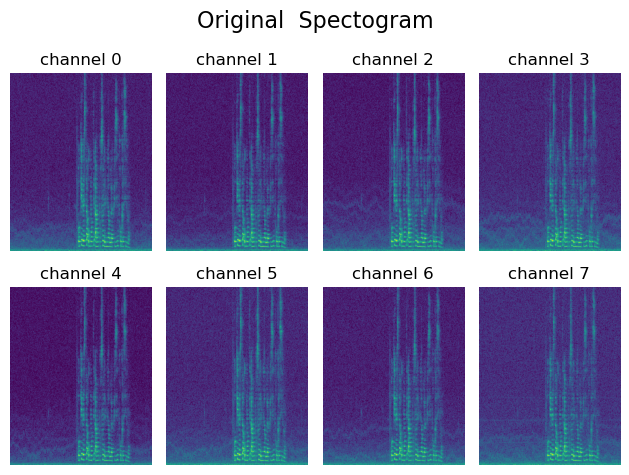

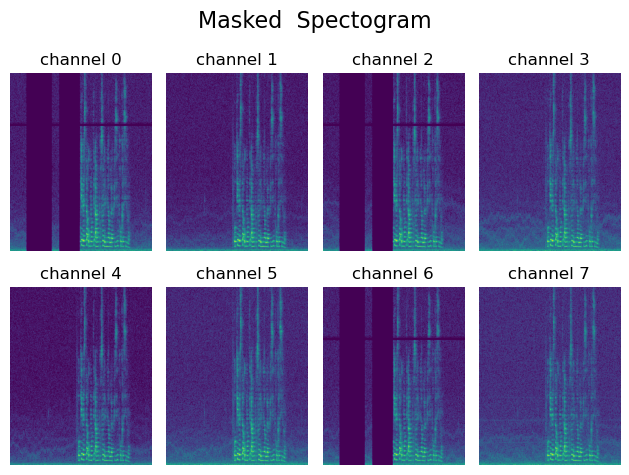

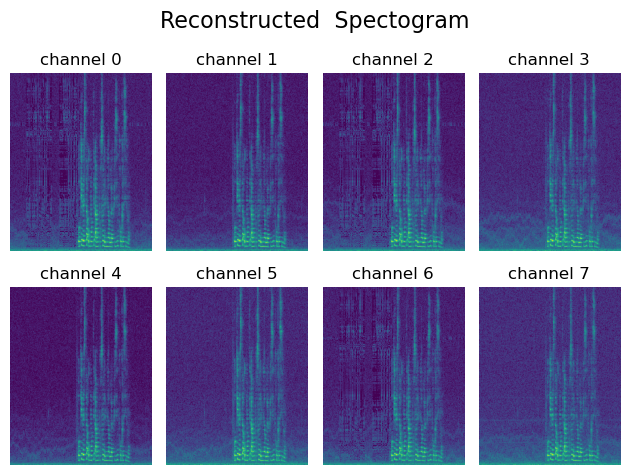

In [15]:
import glob
import pathlib
import os

SPLIT='noisy'
SAMPLE_RATE= 16000
NUMBER_OF_SAMPLES=1#number of data to be considered
NUMBER_OF_MISSING_BLOCKS = 2
NUMBER_OF_MASKED_CHANNELS=3
MASK_TIME_ENABLED = True
MASK_FREQUENCY_ENABLED =True
IID_MASK = True
visualize = True


#  get all audio path

spec_losses = []
paths= glob.glob(os.path.join('./data/voiceHome-2_corpus_1.0/audio',SPLIT,'*.wav'))
print(f"There exists {len(paths)} audio files in {SPLIT} folder.")
paths=paths[:NUMBER_OF_SAMPLES]

for path in paths:
  print(f"--------------------------------------- Start completeing tensor for audio: {path} ---------------------------------------")
  sig, reconstructed_sig,spec, reconstructed_spec= complete_data_pipeline(path, "tt", number_of_masked_channels=NUMBER_OF_MASKED_CHANNELS, number_of_missing_blocks=NUMBER_OF_MISSING_BLOCKS, mask_time_enabled=MASK_TIME_ENABLED, mask_frequency_enabled=MASK_FREQUENCY_ENABLED,iid_mask=IID_MASK, visualize=visualize)
  # calculate loss for  spectogram reconstruction
  spec_losses.append(calculate_mse_loss(spec,reconstructed_spec))


Play the last processed audio file

In [41]:
print("--------------------------------------- Original Audio ---------------------------------------")
Audio(sig.numpy()[0], rate=SAMPLE_RATE)      

--------------------------------------- Original Audio ---------------------------------------


In [42]:
print("--------------------------------------- Imputed Audio Audio  ---------------------------------------")
Audio(reconstructed_sig.numpy()[0], rate=SAMPLE_RATE)

--------------------------------------- Imputed Audio Audio  ---------------------------------------


## Experiment 2: 
Different mask applied on different channels. It could be interpreted as one of the microphone is not working/blocked during some period of time. This could be different for each microphone. In previous example, we assume all affected microphones stop to work at same time or have problem with specfic frequencies. Here, we assume, each microphone is indepented from others.

There exists 1440 audio files in noisy folder.
--------------------------------------- Start completeing tensor for audio: ./data/voiceHome-2_corpus_1.0/audio/noisy/home3_room3_arrayGeo1_arrayPos1_speakerF3_speakerPos2_noiseCond1_uttNum1049.wav ---------------------------------------
AudioMetaData(sample_rate=16000, num_frames=168330, num_channels=8, bits_per_sample=16, encoding=PCM_S)
torch.Size([329, 513, 8]) torch.Size([329, 513, 8])


norm : tensor(0.1048, device='cuda:0')Diff :25.0886298884216: : 30it [00:01, 24.98it/s]  


torch.Size([8, 167936])


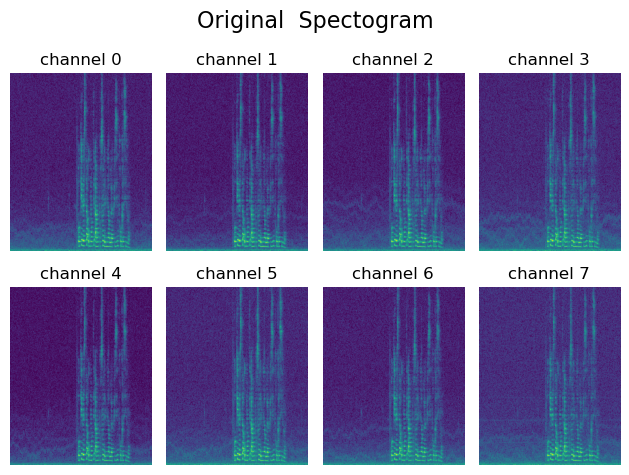

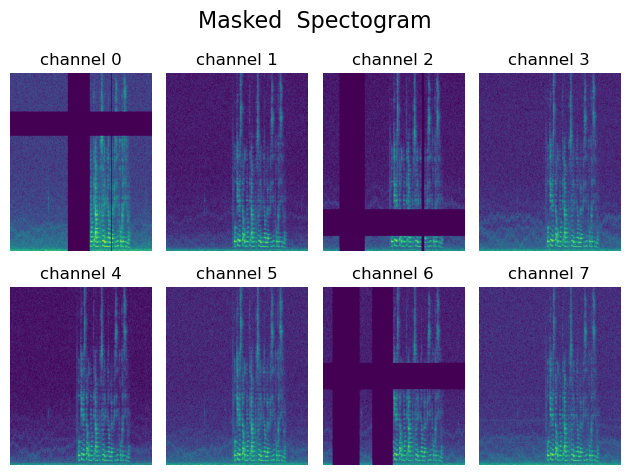

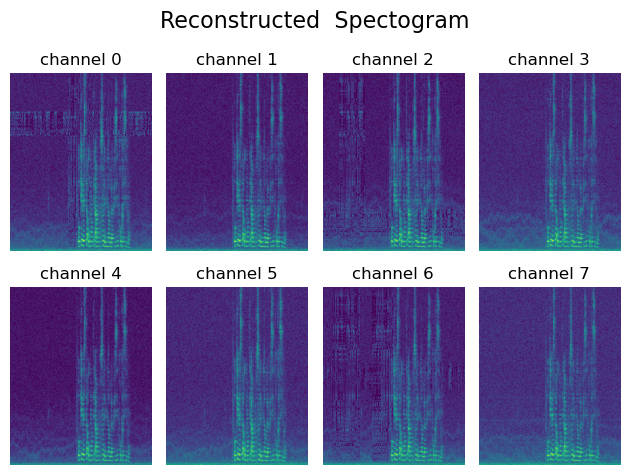

In [17]:
# SPLIT='noisy'
# SAMPLE_RATE= 16000
# NUMBER_OF_SAMPLES=1#number of data to be considered
# NUMBER_OF_MISSING_BLOCKS = 2
# NUMBER_OF_MASKED_CHANNELS=3
# MASK_TIME_ENABLED = True
# MASK_FREQUENCY_ENABLED =True
IID_MASK = False
visualize = True

import glob
import pathlib
import os


#  get all audio path

spec_losses = []
paths= glob.glob(os.path.join('./data/voiceHome-2_corpus_1.0/audio',SPLIT,'*.wav'))
print(f"There exists {len(paths)} audio files in {SPLIT} folder.")
paths=paths[:NUMBER_OF_SAMPLES]

for path in paths:
  print(f"--------------------------------------- Start completeing tensor for audio: {path} ---------------------------------------")
  sig, reconstructed_sig,spec, reconstructed_spec= complete_data_pipeline(path, "tt", number_of_masked_channels=NUMBER_OF_MASKED_CHANNELS, number_of_missing_blocks=NUMBER_OF_MISSING_BLOCKS, mask_time_enabled=MASK_TIME_ENABLED, mask_frequency_enabled=MASK_FREQUENCY_ENABLED,iid_mask=IID_MASK, visualize=visualize)
  # calculate loss for  spectogram reconstruction
  spec_losses.append(calculate_mse_loss(spec,reconstructed_spec))


In [18]:
print("--------------------------------------- Original Audio ---------------------------------------")
Audio(sig.numpy()[0], rate=SAMPLE_RATE)      

--------------------------------------- Original Audio ---------------------------------------


In [19]:
print("--------------------------------------- Imputed Audio Audio  ---------------------------------------")
Audio(reconstructed_sig.numpy()[0], rate=SAMPLE_RATE)

--------------------------------------- Imputed Audio Audio  ---------------------------------------


## Experiment 3: 
Comparisson of different Algorithm


There exists 1440 audio files in noisy folder.
--------------------------------------- Experiment with tr tensor method ---------------------------------------
--------------------------------------- Start completeing tensor for audio: ./data/voiceHome-2_corpus_1.0/audio/noisy/home3_room3_arrayGeo1_arrayPos1_speakerF3_speakerPos2_noiseCond1_uttNum1049.wav ---------------------------------------
AudioMetaData(sample_rate=16000, num_frames=168330, num_channels=8, bits_per_sample=16, encoding=PCM_S)
torch.Size([329, 513, 8]) torch.Size([329, 513, 8])


norm : tensor(7.3227e-05, device='cuda:0')Diff :64.85994779293014: : 11it [00:00, 19.87it/s]


torch.Size([8, 167936])


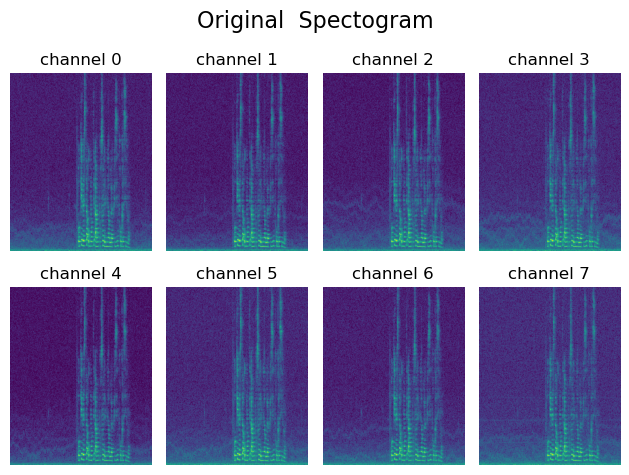

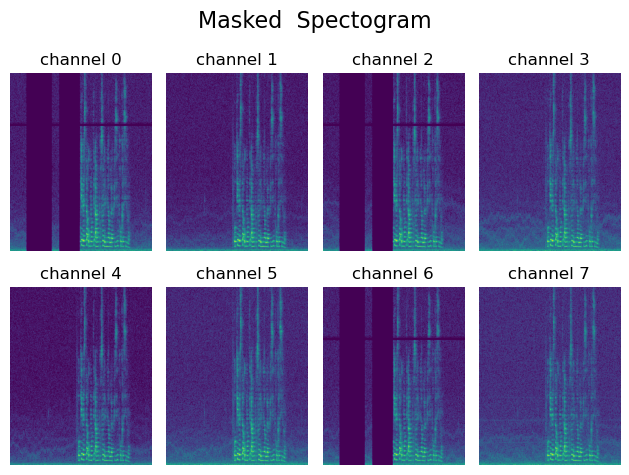

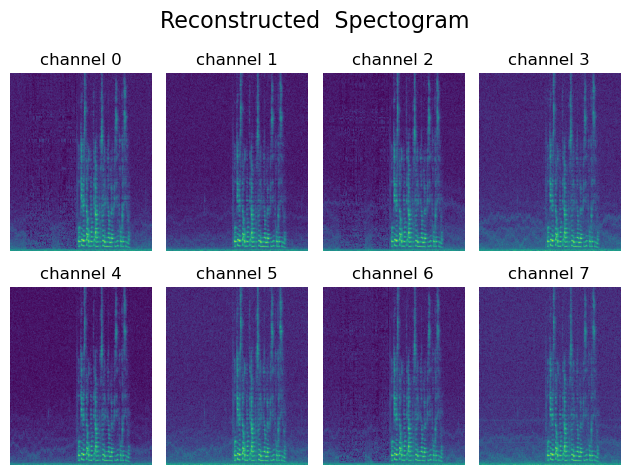

In [21]:
# SPLIT='noisy'
# SAMPLE_RATE= 16000
# NUMBER_OF_SAMPLES=1#number of data to be considered
# NUMBER_OF_MISSING_BLOCKS = 2
# NUMBER_OF_MASKED_CHANNELS=3
# MASK_TIME_ENABLED = True
# MASK_FREQUENCY_ENABLED =True
IID_MASK = True
visualize = True
ALG = 'tr'  #@param ['tr','tt','CP','tucker','lijun','Ali']



import glob
import pathlib
import os


#  get all audio path

spec_losses = []
paths= glob.glob(os.path.join('./data/voiceHome-2_corpus_1.0/audio',SPLIT,'*.wav'))
print(f"There exists {len(paths)} audio files in {SPLIT} folder.")
paths=paths[:NUMBER_OF_SAMPLES]
print(f"--------------------------------------- Experiment with {ALG} tensor method ---------------------------------------")

for path in paths:
  print(f"--------------------------------------- Start completeing tensor for audio: {path} ---------------------------------------")
  sig, reconstructed_sig,spec, reconstructed_spec= complete_data_pipeline(path,ALG , number_of_masked_channels=NUMBER_OF_MASKED_CHANNELS, number_of_missing_blocks=NUMBER_OF_MISSING_BLOCKS, mask_time_enabled=MASK_TIME_ENABLED, mask_frequency_enabled=MASK_FREQUENCY_ENABLED,iid_mask=IID_MASK, visualize=visualize)
  # calculate loss for  spectogram reconstruction
  spec_losses.append(calculate_mse_loss(spec,reconstructed_spec))

In [54]:
print("--------------------------------------- Original Audio ---------------------------------------")
Audio(sig.numpy()[0], rate=SAMPLE_RATE)      

--------------------------------------- Original Audio ---------------------------------------


In [55]:
print("--------------------------------------- Imputed Audio Audio  ---------------------------------------")
Audio(reconstructed_sig.numpy()[0], rate=SAMPLE_RATE)

--------------------------------------- Imputed Audio Audio  ---------------------------------------
